<a href="https://colab.research.google.com/github/IA2021UR/trabajo-ia-en-la-comunidad-de-la-rioja-equipo-1/blob/main/hashing_search_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descargamos los modelos para la detección de caras, que utilizamos en el cuaderno anterior

In [73]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
!wget https://www.dropbox.com/s/uji1ufb009ic3m0/mobilenet_graph.pb?dl=0 -O mobilenet_graph.pb
# Leer mobilenet_graph.pb
with tf.io.gfile.GFile('mobilenet_graph.pb','rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Graph().as_default() as mobilenet:
    tf.import_graph_def(graph_def,name='')

--2021-05-25 13:09:21--  https://www.dropbox.com/s/uji1ufb009ic3m0/mobilenet_graph.pb?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/uji1ufb009ic3m0/mobilenet_graph.pb [following]
--2021-05-25 13:09:21--  https://www.dropbox.com/s/raw/uji1ufb009ic3m0/mobilenet_graph.pb
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0d830e27f3e4fd7db084309e57.dl.dropboxusercontent.com/cd/0/inline/BPINwK829gpk3YfNZMNJVz7uv-BgW4CgFcpPHavQB5NJErwTtRxUoa3BdhY4gB2yg7U5EW-9lWubdk5DQHcd7c_sWxaf-sOegVdVUngTMZiu4pNIsM1qVlCsFsbYLwtUwPFWDxXAwVPnpRdj447OKREC/file# [following]
--2021-05-25 13:09:22--  https://uc0d830e27f3e4fd7db084309e57.dl.dropboxusercontent.com/cd/0/inline/BPINwK829gpk3YfNZMNJVz7uv-BgW4CgFcpPHavQB5NJErwTtRxUoa3BdhY4gB2yg7U

In [ ]:
# import the necessary packages
from imutils import paths
import argparse
import time
import sys
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Esta función está explicada en la anterior sección , obtiene de una imagen un vector(bboxes) que tiene todas las caras que se han podido detectar en la imagen

In [74]:
def detect_faces(image, score_threshold=0.7):
    global boxes, scores
    (imh, imw) = image.shape[:-1]
    img = np.expand_dims(image,axis=0)
    
    # Inicializar mobilenet
    sess = tf.compat.v1.Session(graph=mobilenet)
    image_tensor = mobilenet.get_tensor_by_name('image_tensor:0')
    boxes = mobilenet.get_tensor_by_name('detection_boxes:0')
    scores = mobilenet.get_tensor_by_name('detection_scores:0')
    
    # Predicción (detección)
    (boxes, scores) = sess.run([boxes, scores], feed_dict={image_tensor:img})
    
    # Reajustar tamaños boxes, scores
    boxes = np.squeeze(boxes,axis=0)
    scores = np.squeeze(scores,axis=0)
    
    # Depurar bounding boxes
    idx = np.where(scores>=score_threshold)[0]
    
    # Crear bounding boxes
    bboxes = []
    for index in idx:
        ymin, xmin, ymax, xmax = boxes[index,:]
        (left, right, top, bottom) = (xmin*imw, xmax*imw, ymin*imh, ymax*imh)
        left, right, top, bottom = int(left), int(right), int(top), int(bottom)
        bboxes.append([left,right,top,bottom])
        
    return bboxes



Esta función una vez obtenidas las caras las recorta

In [119]:
def extract_faces(image,bboxes,new_size=(160,160)):
    cropped_faces = []
    for box in bboxes:
        left, right, top, bottom = box
        face = image[top:bottom,left:right]
        cropped_faces.append(cv2.resize(face,dsize=new_size))
    return cropped_faces

Esta función utilizando la librería de tratamiento de imagen lee una imagen desde un directorio


In [135]:
from google.colab.patches import cv2_imshow
def load_image(DIR, NAME):
    return cv2.cvtColor(cv2.imread(f'{DIR}/{name}'), cv2.COLOR_BGR2RGB)

Por facilidad trabajaremos con las 1000 primeras imágenes:
Ahora asignaremos a cada imagen su vector de caras , podría aver algunas imágenes que no tuvieran caras.

In [122]:
#directorio de trabajo
dir='/content/hashing-search-engine/2'
maxImagenes=10


cont=0
listaCaras={}
for name in os.listdir(dir):
  if name.endswith('.jpg'):
    if cont==maxImagenes:
      break
    print(f'   {name}')
    # try:
    image = load_image(dir,name)
    bboxes=detect_faces(image)
    #solo cogemos aquellas imágenes que tengan alguna cara
    if len(bboxes)>0:
      
      faces = extract_faces(image,bboxes)
      listaCaras[name]=faces
    # except:
          # print("An exception occurred")
  cont=cont+1

   449668.jpg
   28885.jpg
   1937.jpg
   469132.jpg
   452415.jpg
   443572.jpg
   581.jpg
   453053.jpg
   43625.jpg
   242.jpg


Mostramos un ejemplo de las imágenes y sus caras asociadas

In [162]:
import shutil
dirPath = '/content/hashing-search-engine/2/'

try:
    shutil.rmtree(dirPath)
except OSError as e:
    print(f"Error:{ e.strerror}")

In [188]:
s='449668.jpg'
posicion=s.index('.')
print(s[0:posicion])

449668


3/449668_0.jpg
3/449668_1.jpg
3/449668_2.jpg
3/449668_3.jpg
3/449668_4.jpg
3/449668_5.jpg
3/449668_6.jpg
3/449668_7.jpg
3/449668_8.jpg
3/449668_9.jpg
3/449668_10.jpg
3/449668_11.jpg
3/449668_12.jpg
3/28885_0.jpg
3/28885_1.jpg
3/28885_2.jpg
3/28885_3.jpg
3/28885_4.jpg
3/28885_5.jpg
3/28885_6.jpg
3/28885_7.jpg
3/28885_8.jpg
3/1937_0.jpg
3/1937_1.jpg
3/1937_2.jpg
3/1937_3.jpg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


3/1937_4.jpg
3/469132_0.jpg
3/469132_1.jpg
3/469132_2.jpg
3/469132_3.jpg
3/469132_4.jpg
3/469132_5.jpg
3/469132_6.jpg
3/469132_7.jpg
3/469132_8.jpg
3/469132_9.jpg
3/469132_10.jpg
3/452415_0.jpg
3/452415_1.jpg
3/452415_2.jpg
3/443572_0.jpg
3/443572_1.jpg
3/581_0.jpg
3/581_1.jpg
3/453053_0.jpg
3/453053_1.jpg
3/43625_0.jpg
3/43625_1.jpg
3/43625_2.jpg
3/43625_3.jpg


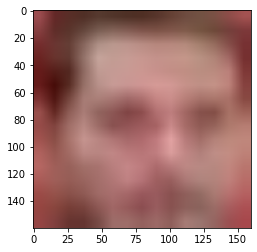

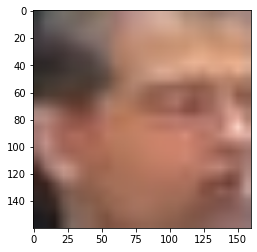

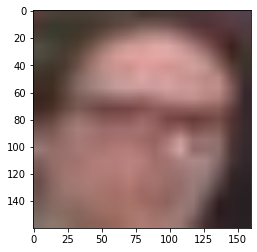

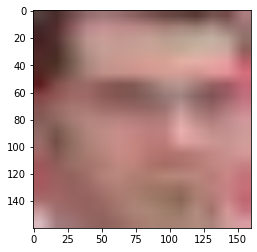

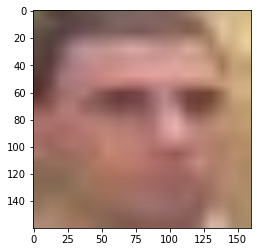

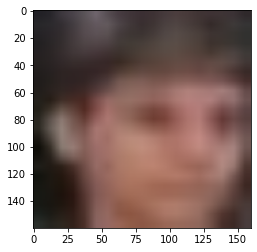

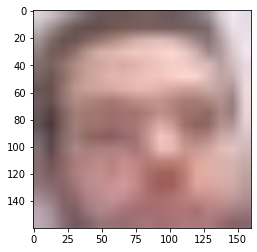

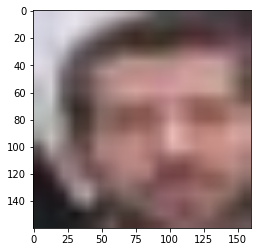

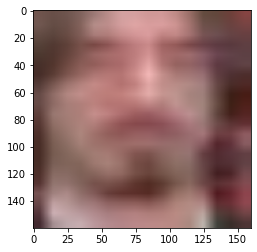

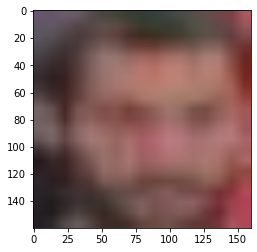

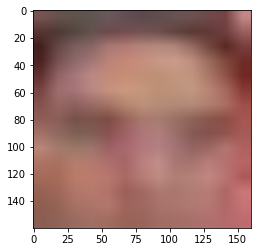

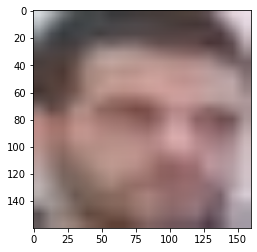

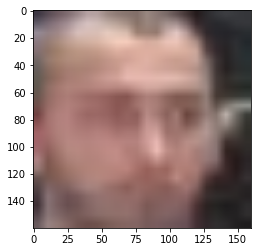

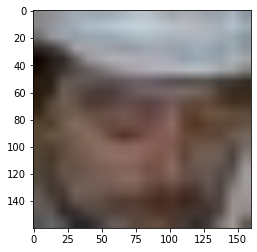

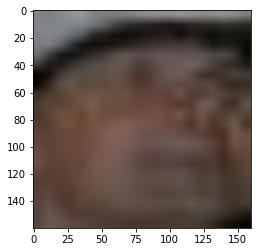

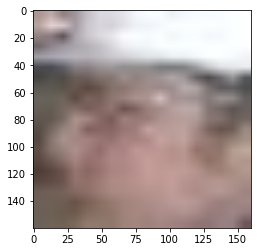

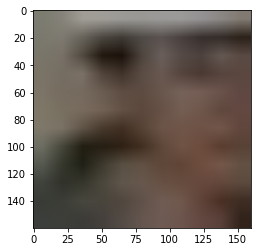

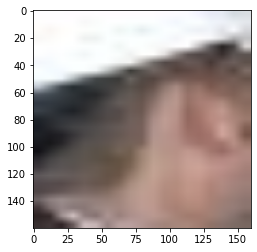

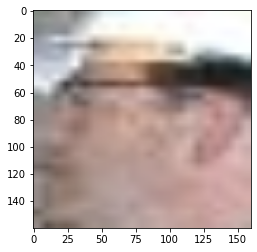

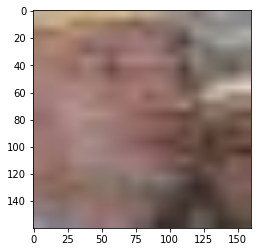

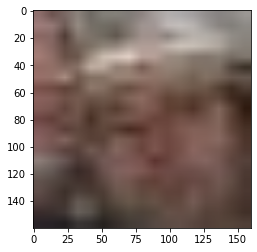

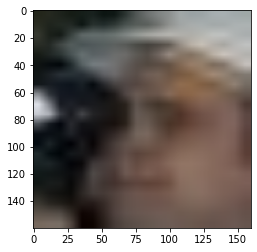

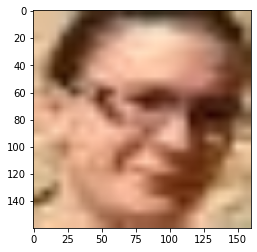

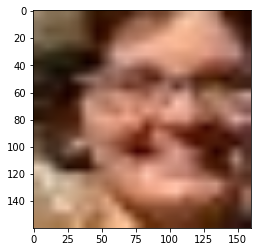

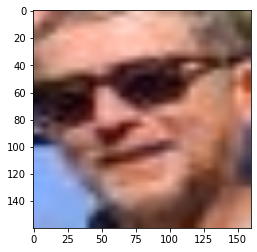

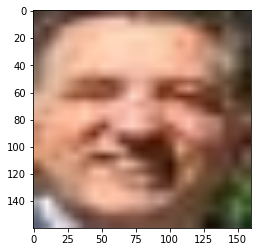

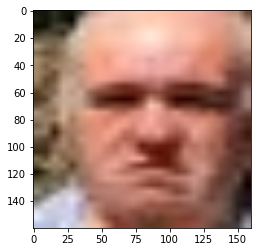

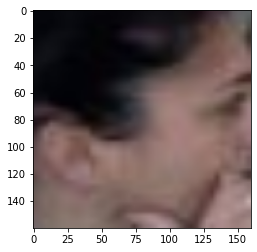

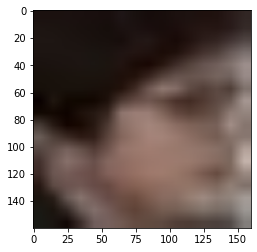

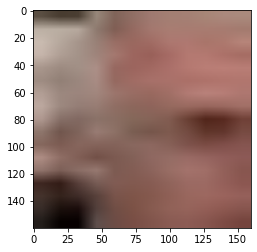

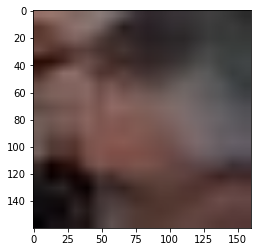

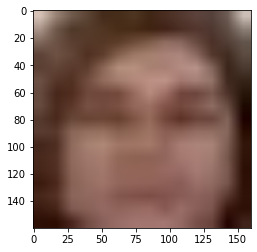

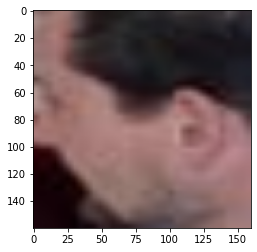

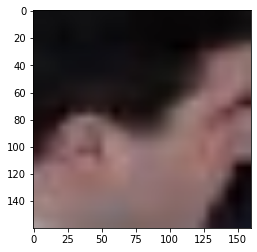

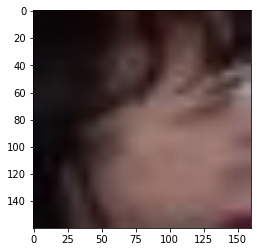

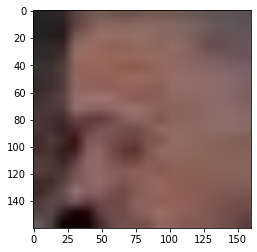

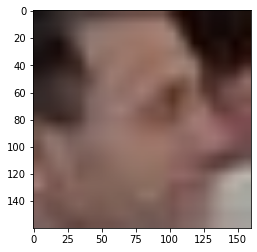

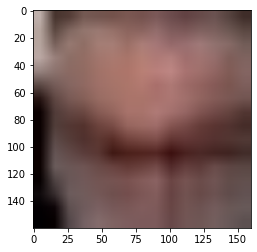

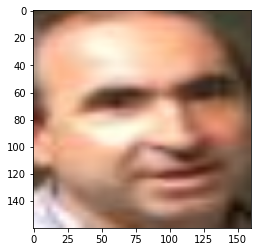

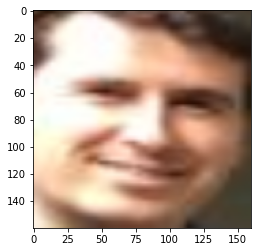

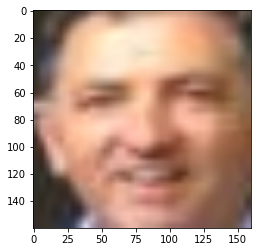

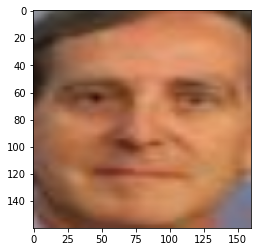

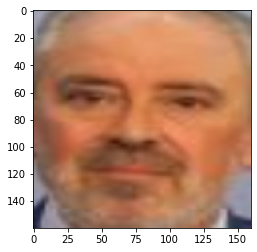

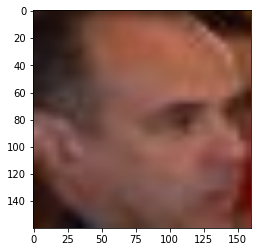

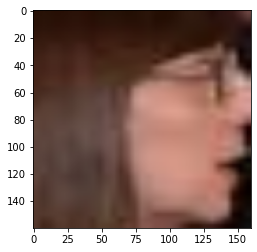

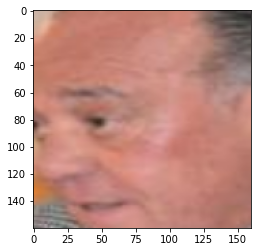

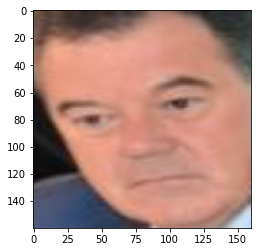

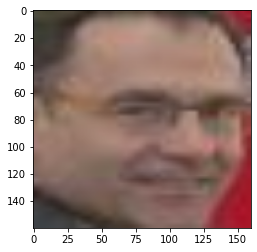

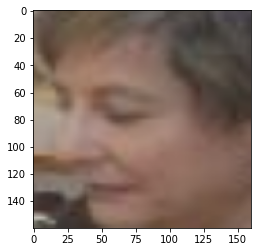

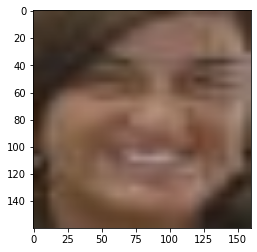

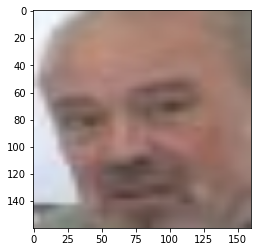

In [206]:
for imagenConCara in listaCaras:
  # print(imagenConCara)
  b=listaCaras[imagenConCara]
  i=0
  for el in b:
    plt.figure()
    plt.imshow(el)
    posicion=imagenConCara.index('.')
    nombre='3/'+imagenConCara[0:posicion]+'_'+str(i)+'.jpg'
    print(nombre)
    i=i+1

    cv2.imwrite(nombre, el)


Una vez que ya disponemos de las imágenes de las caras utilizaremos las búsquedas con vptrees.

VPTrees y Hashing para la búsqueda de imágenes

In [78]:
!pip install opencv-contrib-python
!pip install vptree

### Download the code zip file

In [79]:
!wget https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/image-hashing-search-engine/hashing-search-engine.zip
!unzip -qq hashing-search-engine.zip
%cd hashing-search-engine

--2021-05-25 13:09:41--  https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/image-hashing-search-engine/hashing-search-engine.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.180.88
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.180.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113505 (111K) [application/zip]
Saving to: ‘hashing-search-engine.zip.1’

hashing-search-engi 100%[===================>] 110.84K   448KB/s    in 0.2s    

2021-05-25 13:09:41 (448 KB/s) - ‘hashing-search-engine.zip.1’ saved [113505/113505]

replace hashing-search-engine/index_images.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
/content/hashing-search-engine/hashing-search-engine


Dataset del gobierno de la rioja

In [ ]:
!wget https://www.dropbox.com/s/chfwr4x475y3p1v/noticiasFotos.zip?dl=0 -O 2.zip
!unzip 2.zip

## Blog Post Code

### Import Packages

In [96]:
# import the necessary packages
from imutils import paths
import matplotlib.pyplot as plt
import argparse
import pickle
import vptree
import time
import cv2
import os

### Function to display images in Jupyter Notebooks and Google Colab

In [97]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Implementing our image hashing utilities

In [98]:
def dhash(image, hashSize=8):
	# convert the image to grayscale
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	
	# resize the input image, adding a single column (width) so we
	# can compute the horizontal gradient
	resized = cv2.resize(gray, (hashSize + 1, hashSize))

	# compute the (relative) horizontal gradient between adjacent
	# column pixels
	diff = resized[:, 1:] > resized[:, :-1]

	# convert the difference image to a hash
	return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

In [99]:
def convert_hash(h):
	# convert the hash to NumPy's 64-bit float and then back to
	# Python's built in int
	return int(np.array(h, dtype="float64"))

In [100]:
def hamming(a, b):
	# compute and return the Hamming distance between the integers
	return bin(int(a) ^ int(b)).count("1")

### Implementing our image hash indexer

In [101]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--images", required=True, type=str,
# 	help="path to input directory of images")
# ap.add_argument("-t", "--tree", required=True, type=str,
# 	help="path to output VP-Tree")
# ap.add_argument("-a", "--hashes", required=True, type=str,
# 	help="path to output hashes dictionary")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "images": "2",
    "tree": "vptree.pickle",
    "hashes": "hashes.pickle"
}

In [ ]:
# grab the paths to the input images and initialize the dictionary
# of hashes
imagePaths = list(paths.list_images(args["images"]))
hashes = {}

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
	# load the input image
  try:
    print("[INFO] processing image {}/{}".format(i + 1,
      len(imagePaths)))
    image = cv2.imread(imagePath)

    # compute the hash for the image and convert it
    h = dhash(image)
    h = convert_hash(h)

    # update the hashes dictionary
    l = hashes.get(h, [])
    l.append(imagePath)
    hashes[h] = l
  except:
    print('error')

In [103]:
# build the VP-Tree
print("[INFO] building VP-Tree...")
points = list(hashes.keys())
tree = vptree.VPTree(points, hamming)

[INFO] building VP-Tree...


In [104]:
# serialize the VP-Tree to disk
print("[INFO] serializing VP-Tree...")
f = open(args["tree"], "wb")
f.write(pickle.dumps(tree))
f.close()

# serialize the hashes to dictionary
print("[INFO] serializing hashes...")
f = open(args["hashes"], "wb")
f.write(pickle.dumps(hashes))
f.close()

[INFO] serializing VP-Tree...
[INFO] serializing hashes...


### Implementing our image hash searching script

**Busqueda de una cara** , nota por simplicidad utilizaremos fotos con una sola cara .

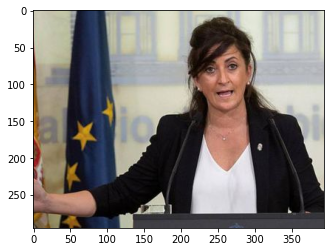

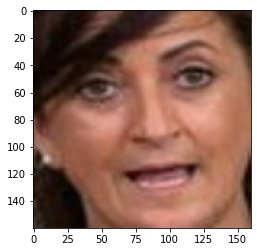

In [177]:
#1.leemos la foto y extraemos la cara
img=cv2.cvtColor(cv2.imread('/content/prueba.jpg'), cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(img)

#2 Detectamos la cara y la extraemos
bboxes=detect_faces(img)
cara= extract_faces(img,bboxes)
plt.figure()
plt.imshow(cara[0])


In [147]:
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-t", "--tree", required=True, type=str,
# 	help="path to pre-constructed VP-Tree")
# ap.add_argument("-a", "--hashes", required=True, type=str,
# 	help="path to hashes dictionary")
# ap.add_argument("-q", "--query", required=True, type=str,
# 	help="path to input query image")
# ap.add_argument("-d", "--distance", type=int, default=10,
# 	help="maximum hamming distance")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "tree": "vptree.pickle",
    "hashes": "hashes.pickle",
    "query": "queries/face.jpg",
    "distance": 10
}

[INFO] loading VP-Tree and hashes...


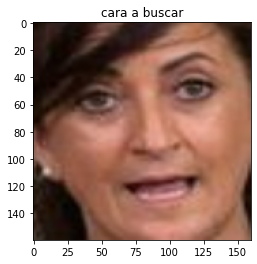

HASH imagen:
14166277914156781230


In [203]:
# load the VP-Tree and hashes dictionary
print("[INFO] loading VP-Tree and hashes...")
tree = pickle.loads(open(args["tree"], "rb").read())
hashes = pickle.loads(open(args["hashes"], "rb").read())

# load the input query image
# image = cv2.imread('/content/hashing-search-engine/queries/a.jpg')
plt.imshow(cara[0])
plt.title('cara a buscar')
plt.show()

# compute the hash for the query image, then convert it
queryHash = dhash(image)
print('HASH imagen:')
print(queryHash)
queryHash = convert_hash(queryHash)

In [108]:
# perform the search
print("[INFO] performing search...")
start = time.time()
results = tree.get_all_in_range(queryHash, args["distance"])
results = sorted(results)
end = time.time()
print("[INFO] search took {} seconds".format(end - start))

[INFO] performing search...
[INFO] search took 0.055832624435424805 seconds


In [109]:
results

[]

In [110]:
# loop over the results
for (d, h) in results:
	# grab all image paths in our dataset with the same hash
	resultPaths = hashes.get(h, [])
	print("[INFO] {} total image(s) with d: {}, h: {}".format(
		len(resultPaths), d, h))

	# loop over the result paths
	for resultPath in resultPaths:
		# load the result image and display it to our screen
		result = cv2.imread(resultPath)
		plt_imshow("Result", result)